In [1]:
from keras.datasets import mnist
from keras.layers import *
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

import numpy as np
import matplotlib.pyplot as plt
import math

Using TensorFlow backend.


In [2]:
(x_train,_),(_,_) = mnist.load_data()

In [3]:
print(x_train.shape)

(60000, 28, 28)


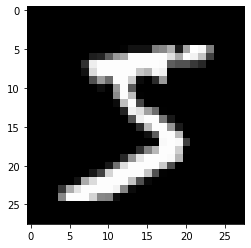

In [4]:
plt.imshow(x_train[0],cmap='gray')
plt.show()

In [7]:
print(x_train.shape)
x_train=x_train.reshape((*x_train.shape,1))
print(x_train.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


In [8]:
x_train  = (x_train.astype('float32') - 127.5)/127.5
print(np.min(x_train))
print(np.max(x_train))

print(x_train.shape)

-1.0
1.0
(60000, 28, 28, 1)


In [9]:
Total_epochs = 50
Batch_size = 256
No_of_batches = int(x_train.shape[0]/Batch_size) 
minibatch = 128
noise_dim = 100 # Upsample into 784 Dim Vector
adam = Adam(lr=2e-4,beta_1=0.5)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
#defining the generator
generator=Sequential()
generator.add(Dense(7*7*128,input_shape=(noise_dim,)))
generator.add(Reshape((7,7,128)))
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization()) #batch normalization id added after non linearity


#upsampling the image(double the activation size) into 14*14*64

generator.add(UpSampling2D())   #upsampling done  i.e 14*14*128

generator.add(Conv2D(64,kernel_size=(5,5),padding='same'))   #will conert into 14*14*64
generator.add(LeakyReLU(0.2))
generator.add(BatchNormalization())


#upsampling the image(double the activation size) into 28*28*1
generator.add(UpSampling2D())   #upsampling done i.e 28*28*64
generator.add(Conv2D(1,kernel_size=(5,5),padding='same',activation='tanh'))   #will conert into 28*28*1

generator.compile(loss='binary_crossentropy',optimizer='adam')
generator.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 6272)              633472    
_________________________________________________________________
reshape_1 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)       

In [13]:
#defining the discriminator 
discriminator=Sequential()
discriminator.add(Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=(28,28,1)))  #(28,28,1)--->(14,14,64)
discriminator.add(LeakyReLU(0.2))

discriminator.add(Conv2D(128,(5,5),strides=(2,2),padding='same'))            #(14,14,64)----->(7,7,128)
discriminator.add(LeakyReLU(0.2))

discriminator.add(Flatten())                                                #will flat 7*7*128 into single Dimension
discriminator.add(Dense(1,activation='sigmoid'))

discriminator.compile(loss='binary_crossentropy',optimizer=adam)
discriminator.summary()


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6273      
Total params: 212,865
Trai

In [14]:
discriminator.trainable = False
gan_input = Input(shape=(noise_dim,))
generated_img = generator(gan_input)
gan_output = discriminator(generated_img)

# Functional API
model = Model(gan_input,gan_output)
model.compile(loss='binary_crossentropy',optimizer=adam)

In [15]:
def saveimages(epoch,samples=100):
    noise=np.random.normal(0,1,size=(samples,noise_dim))
    generated_images=generator.predict(noise)
    generated_images=generated_images.reshape(samples,28,28)
    
    plt.figure(figsize=(10,10))
    for i in range(samples):
        plt.subplot(10,10,i+1)
        plt.imshow(generated_images[i],interpolation='nearest',cmap='gray')
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('DCGAN/images/gan_output_epoch_no_{0}.png'.format(epoch+1))
    plt.show()

c:\python\python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
c:\python\python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
c:\python\python37\lib\site-packages\keras\engine\training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1 Disc Loss 0.2460 Generator Loss 0.2149
Epoch 2 Disc Loss 0.7091 Generator Loss 0.8449


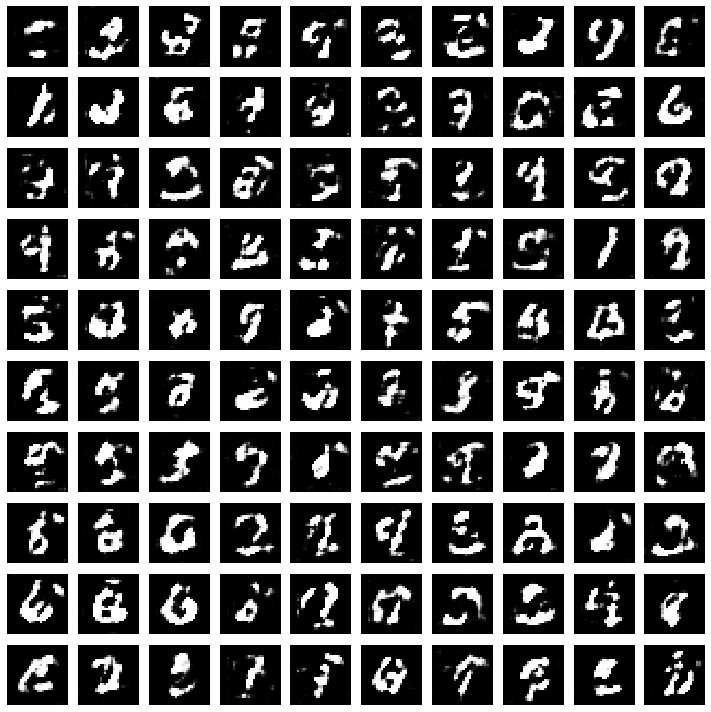

Epoch 3 Disc Loss 0.6836 Generator Loss 0.8653
Epoch 4 Disc Loss 0.6868 Generator Loss 0.8453


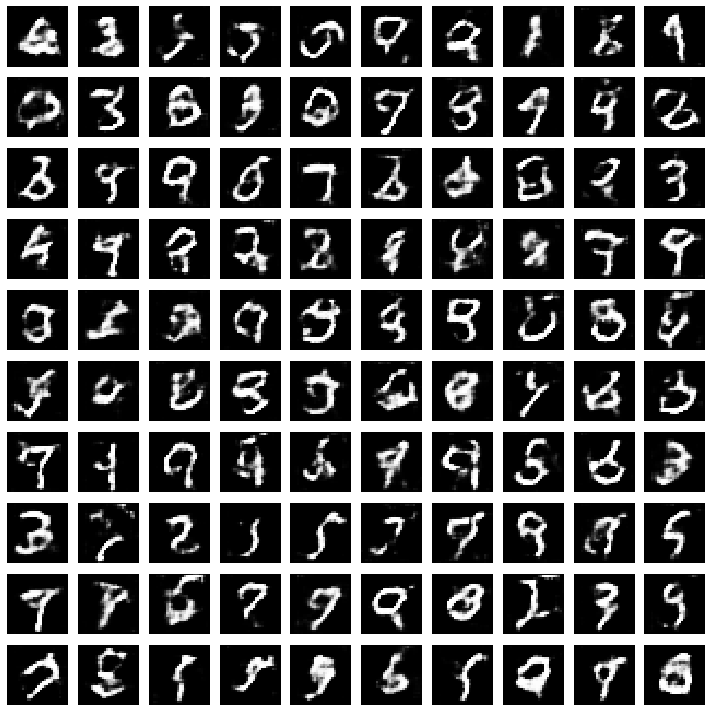

Epoch 5 Disc Loss 0.6897 Generator Loss 0.8284
Epoch 6 Disc Loss 0.6887 Generator Loss 0.8282


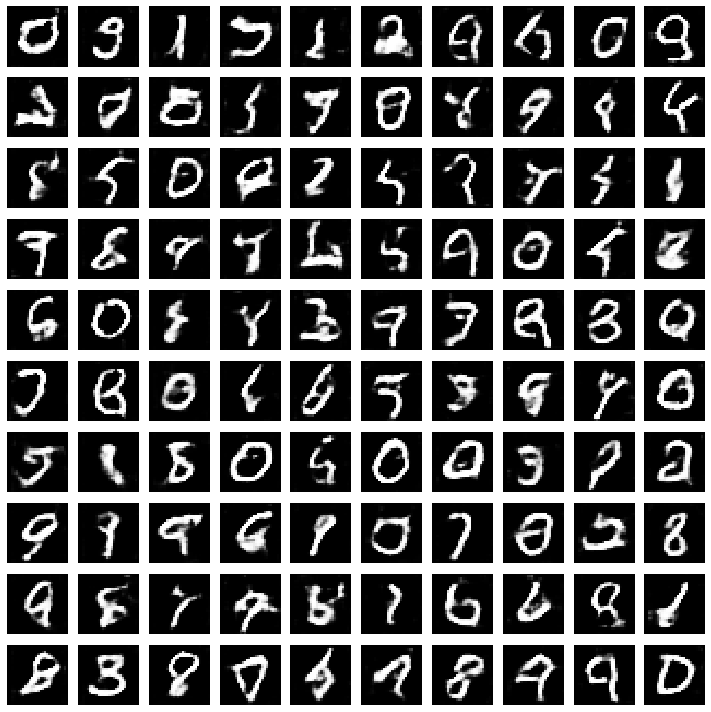

Epoch 7 Disc Loss 0.6881 Generator Loss 0.8264
Epoch 8 Disc Loss 0.6874 Generator Loss 0.8305


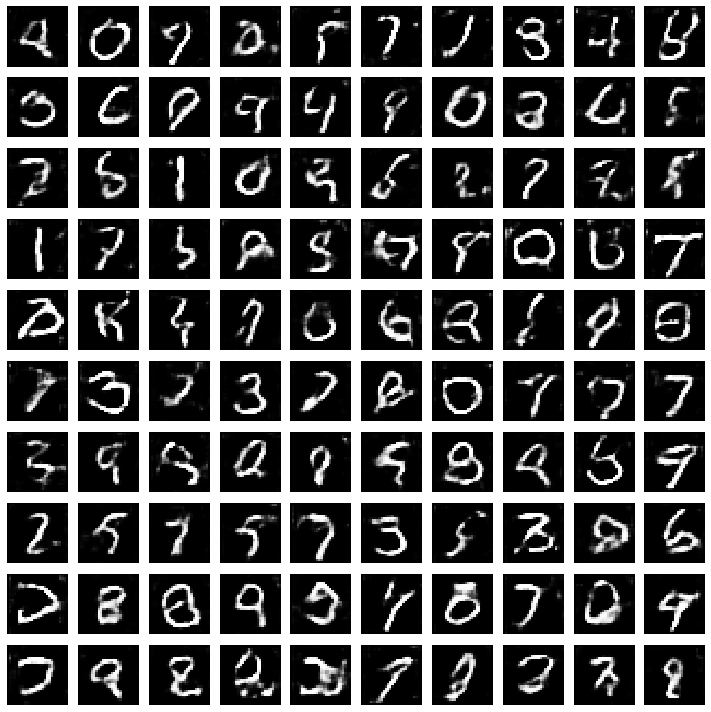

Epoch 9 Disc Loss 0.6868 Generator Loss 0.8285
Epoch 10 Disc Loss 0.6853 Generator Loss 0.8360


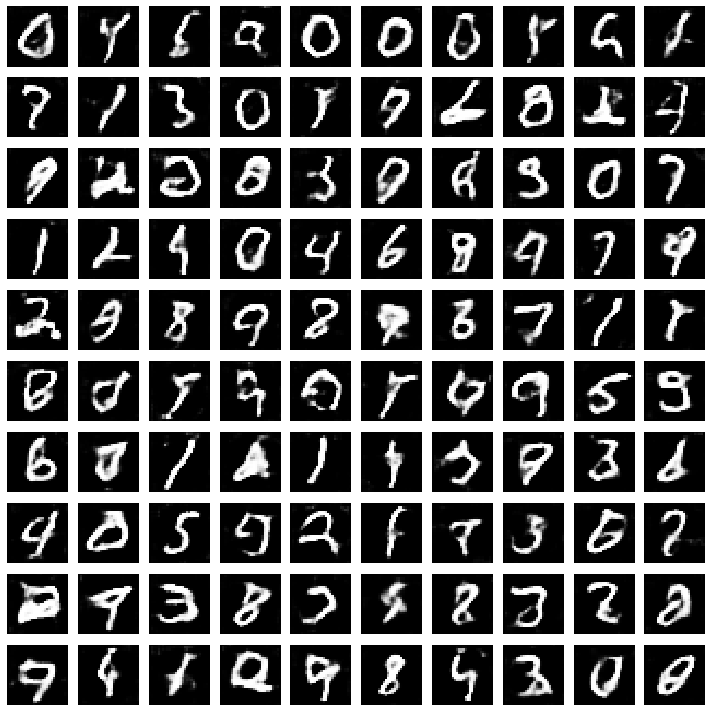

Epoch 11 Disc Loss 0.6853 Generator Loss 0.8322
Epoch 12 Disc Loss 0.6842 Generator Loss 0.8393


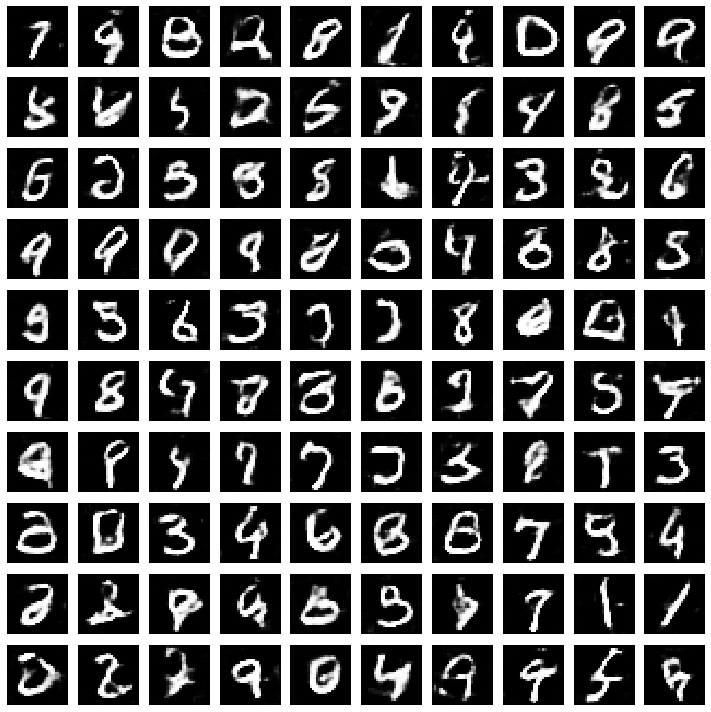

Epoch 13 Disc Loss 0.6837 Generator Loss 0.8375
Epoch 14 Disc Loss 0.6840 Generator Loss 0.8316


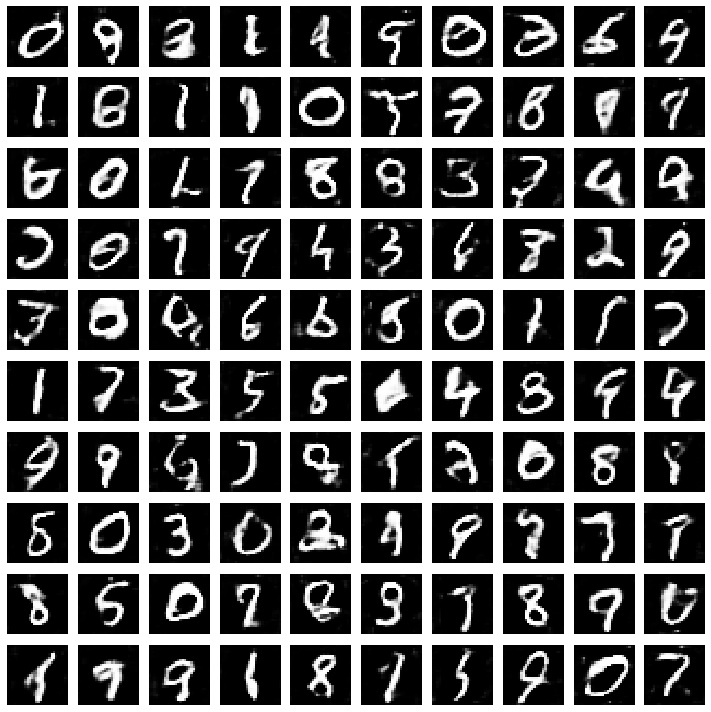

Epoch 15 Disc Loss 0.6829 Generator Loss 0.8417
Epoch 16 Disc Loss 0.6823 Generator Loss 0.8433


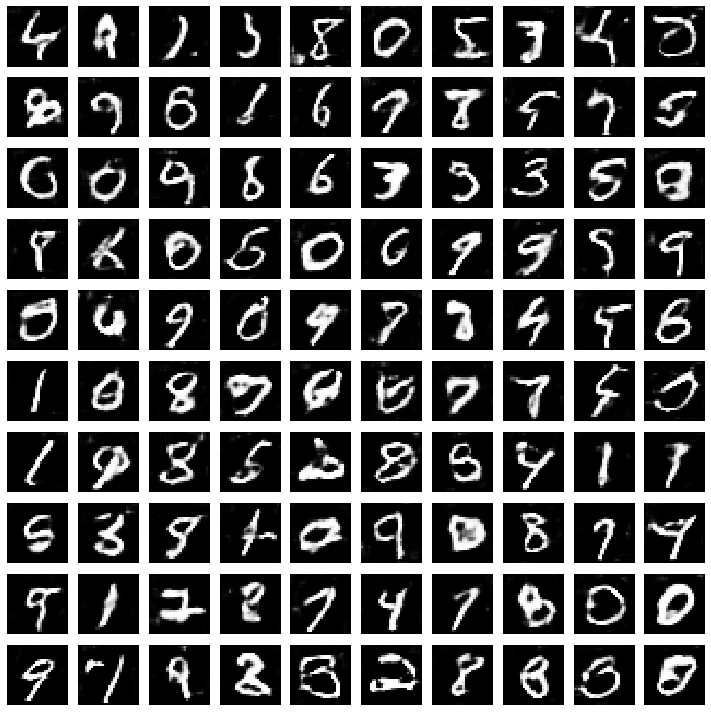

Epoch 17 Disc Loss 0.6827 Generator Loss 0.8373
Epoch 18 Disc Loss 0.6808 Generator Loss 0.8561


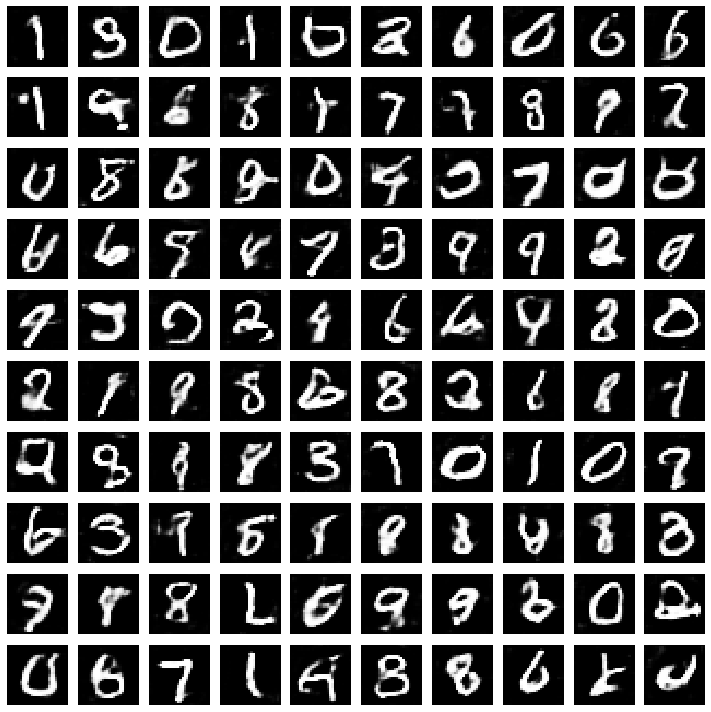

Epoch 19 Disc Loss 0.6814 Generator Loss 0.8423
Epoch 20 Disc Loss 0.6802 Generator Loss 0.8557


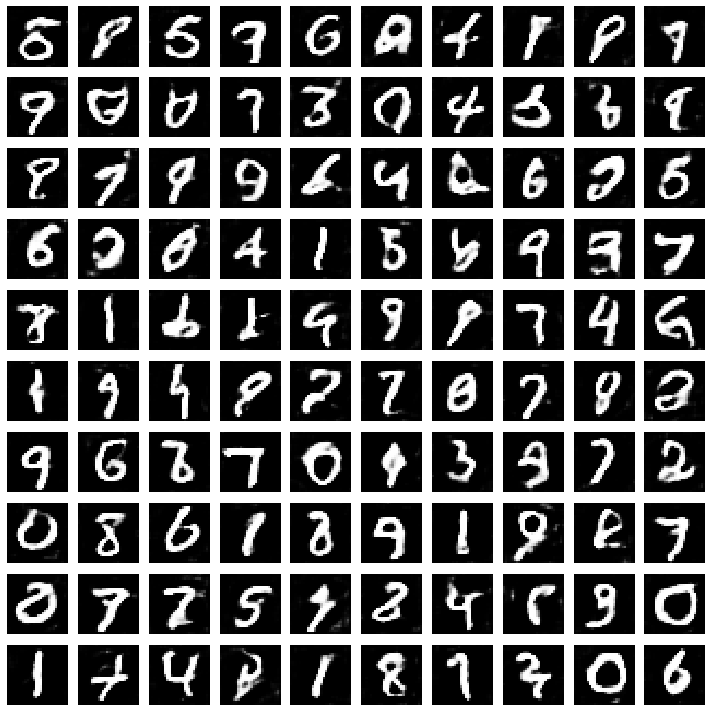

Epoch 21 Disc Loss 0.6799 Generator Loss 0.8500
Epoch 22 Disc Loss 0.6797 Generator Loss 0.8511


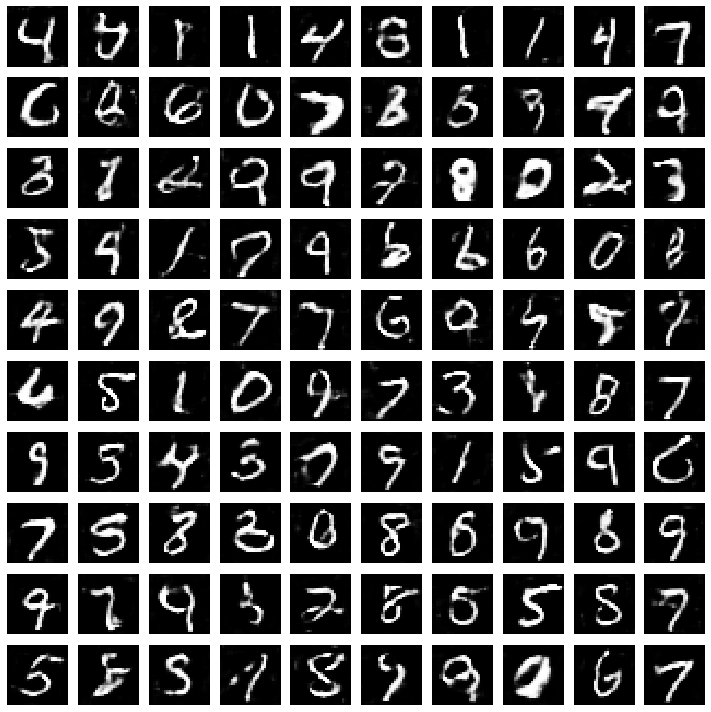

In [ ]:
disc_losses = []
gene_losses = []


for epoch in range(Total_epochs):
    epoch_disc_loss = 0.
    epoch_gene_loss = 0.
    
    #Mini Batch SGD
    for step in range(No_of_batches):
        
        # Step-1 Discriminator 
        # 50% Real Data + 50% Fake Data
        
        #Real Data X
        idx = np.random.randint(0,x_train.shape[0],minibatch)
        real_imgs = x_train[idx]
        
        #Fake Data X
        noise = np.random.normal(0,1,size=(minibatch,noise_dim))
        fake_imgs = generator.predict(noise) #Forward 
        
        
        # Labels 
        real_y = np.ones((minibatch,1))*0.9 #One Side Label Smoothing for Discriminator
        fake_y = np.zeros((minibatch,1))
        
        # Train our Discriminator
        disc_loss_real = discriminator.train_on_batch(real_imgs,real_y)
        disc_loss_fake = discriminator.train_on_batch(fake_imgs,fake_y)
        disc_loss = 0.5*disc_loss_real + 0.5*disc_loss_fake
        
        epoch_disc_loss += disc_loss
        
        # Train Generator (Considering Frozen Discriminator)
        noise = np.random.normal(0,1,size=(Batch_size,noise_dim))
        ground_truth_y = np.ones((Batch_size,1))
        gene_loss = model.train_on_batch(noise,ground_truth_y)
        epoch_gene_loss += gene_loss
        
    print("Epoch %d Disc Loss %.4f Generator Loss %.4f" %((epoch+1),epoch_disc_loss/No_of_batches,epoch_gene_loss/No_of_batches))
    disc_losses.append(epoch_disc_loss/No_of_batches)
    gene_losses.append(epoch_gene_loss/No_of_batches)
    
    
    if (epoch+1)%2==0:
        generator.save("DCGAN/models/gana_generator_{0}.h5".format(epoch+1))
        saveimages(epoch)
        

In [ ]:
plt.plot(disc_losses,label='discriminator')
plt.plot(gene_losses,label='generator')
plt.legend()
plt.show()